LSTM
======


In [161]:
# importing libraries
import os
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
import librosa as lib
import tensorflow as tf

In [51]:
valid_data = pd.read_csv("../valid_data.csv")

# we need phone position, affect, file_path, then the local file path
valid_data["file_path"] = valid_data["file_name"].str.replace("/media/data/shout-data/", "/dataset/")
valid_data["file_path"] = valid_data["file_path"].str.replace(".wav", "")
valid_data["file_path"] = valid_data["file_path"].astype(str) + valid_data["chunk_name"].astype(str)

processingSet = valid_data[["affect", "file_path", "phone_position"]]

testSet = valid_data.sample(n=100, random_state=100)
testSet.to_csv("../test_set.csv")

trainingSet = valid_data.drop(testSet.index)
trainingSet.to_csv("../training_set.csv")

In [52]:
valid_data = pd.read_csv("../valid_data.csv")

# we need phone position, affect, file_path, then the local file path
valid_data["file_path"] = valid_data["file_name"].str.replace("/media/data/shout-data/", "../dataset/")
valid_data["file_path"] = valid_data["file_path"].str.replace(".wav", "")
valid_data["file_path"] = valid_data["file_path"].astype(str) + valid_data["chunk_name"].astype(str)

processingSet = valid_data[["affect", "file_path", "phone_position"]]
processingSet

,affect,file_path,phone_position
0,sadness,../dataset/shout_data_3afd7208-7987-4c73-8e01-...,Place phone on the opposite side of the room i...
1,neutral,../dataset/shout_data_ae6feb35-cf7a-4805-8d05-...,Hold your phone next to your face but with the...
2,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...
3,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...
4,disgust,../dataset/shout_data_739dbf1c-ec21-42db-9e49-...,Place phone 1-2 meters away face up on any sur...
...,...,...,...
3048,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3049,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3050,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3051,fear,../dataset/shout_data_d5d4e179-d411-4652-b80b-...,Place phone 1-2 meters away face down on a har...


In [199]:
FRAME_SIZE = 512 # the size of the frame
HOP_LENGTH = 256 # the distance each frame jumps by
FRAME_LENGTH = 512 # length of a frame

def getFeatures(audioSignal, sample_rate):
    
    # duration of 1 sample
    oneSampleDuration = 1/sample_rate
    
    # duration of audio signal in seconds
    sampleDuration = oneSampleDuration*len(audioFile)
    
    ae, time = getAmplitudeEnvelope(audioSignal)
    rms = getRMS(audioSignal)
    zcr = getZCR(audioSignal)
    
    return time, ae, rms, zcr
    
def getAmplitudeEnvelope(audioSignal):
    amplitudeEnvelope = []
    
    for i in range(0, len(audioSignal), HOP_LENGTH):
        currentFrameAE = max(audioSignal[i:i+FRAME_SIZE])
        amplitudeEnvelope.append(currentFrameAE)
        
    amplitudeEnvelope = np.array(amplitudeEnvelope)
    amplitudeFrames = range(0, amplitudeEnvelope.size)
    time = lib.frames_to_time(amplitudeFrames, hop_length=HOP_LENGTH)
    
    return amplitudeEnvelope, time
    
def getRMS(audioSignal):
    rms = []
    for i in range(0, len(audioSignal), HOP_LENGTH):
        rms_current = np.sqrt(np.sum(audioSignal[i:i+FRAME_LENGTH]**2) / FRAME_LENGTH)
        rms.append(rms_current)
    return rms

def getZCR(audioSignal):
    return lib.feature.zero_crossing_rate(audioSignal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

def calc_sfb(spec, freq, sr):
    freq_range = sr/2
    freq_delta = freq_range / spec.shape[0]
    return int(np.floor(freq / freq_delta))
def calc_ber(spec, freq, sr):
    sfb = calc_sfb(spec, freq, sr)
    pSpec = np.abs(spec) ** 2
    pSpec = pSpec.T
    ber = []

    for freqs in pSpec:
        sum_low = np.sum(freqs[:sfb])
        sum_high = np.sum(freqs[sfb:])
        ber_current = sum_low/sum_high
        ber.append(ber_current)

    return np.array(ber)
def getFrequencyFeatures(audioSignal, sample_rate):
    audio_spec = lib.stft(audioFile, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    centroid = lib.feature.spectral_centroid(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    bandwidth = lib.feature.spectral_bandwidth(y=audioFile, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
    ber = calc_ber(audio_spec, 2000, sample_rate)
    return centroid, bandwidth, ber

zeroCrossingRateList = []
amplitudeEnvelopeList = []
rootMeanSquareEnergyList = []
spectralCentroidList = []
spectralBandwidthList = []
bandEnergyRatioList = []
timings = []
audioFileLengths = []

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    audioFileLengths.append(len(audioFile))

maxAudioLength = max(audioFileLengths)    

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    audioFile = lib.util.pad_center(audioFile, size=maxAudioLength)
    time, ae, rmse, zcr = getFeatures(audioFile, sample_rate)
    centroid, bandwidth, ber = getFrequencyFeatures(audioFile, sample_rate)
    zeroCrossingRateList.append(zcr)
    amplitudeEnvelopeList.append(ae)
    rootMeanSquareEnergyList.append(rmse)
    spectralCentroidList.append(centroid)
    spectralBandwidthList.append(bandwidth)
    bandEnergyRatioList.append(ber)
    timings.append(time)
    
processingSet["Timings"] = timings
processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
processingSet["Root_Mean_Square_Energy"] = rootMeanSquareEnergyList
processingSet["Zero-Crossing Rate"] = zeroCrossingRateList
processingSet["Spectral Centroid"] = spectralCentroidList
processingSet["Spectral Bandwidth"] = spectralBandwidthList
processingSet["Band Energy Ratio"] = bandEnergyRatioList
trainingSetProcessed = processingSet.drop(testSet.index)
testSetProcessed = processingSet.drop(trainingSetProcessed.index)
processingSet

C:\Users\Andre\AppData\Local\Temp\ipykernel_20484\3302324181.py:59: RuntimeWarning: invalid value encountered in scalar divide
  ber_current = sum_low/sum_high
C:\Users\Andre\AppData\Local\Temp\ipykernel_20484\3302324181.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processingSet["Timings"] = timings
C:\Users\Andre\AppData\Local\Temp\ipykernel_20484\3302324181.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
C:\Users\Andre\AppData\Local\

,affect,file_path,phone_position,Timings,Amplitude_Envelope,Root_Mean_Square_Energy,Zero-Crossing Rate,Spectral Centroid,Spectral Bandwidth,Band Energy Ratio
0,sadness,../dataset/shout_data_3afd7208-7987-4c73-8e01-...,Place phone on the opposite side of the room i...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,neutral,../dataset/shout_data_ae6feb35-cf7a-4805-8d05-...,Hold your phone next to your face but with the...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,disgust,../dataset/shout_data_739dbf1c-ec21-42db-9e49-...,Place phone 1-2 meters away face up on any sur...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...,...,...,...,...,...,...
3048,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3049,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3050,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..

In [54]:
# audio processing and getting features
zeroCrossingRateList = []
amplitudeEnvelopeList = []
rootMeanSquareEnergyList = []
timings = []
audioFileLengths = []

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    audioFileLengths.append(len(audioFile))

maxAudioLength = max(audioFileLengths)    

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    time, ae, rmse, zcr = getFeatures(audioFile, sample_rate, maxAudioLength)
    zeroCrossingRateList.append(zcr)
    amplitudeEnvelopeList.append(ae)
    rootMeanSquareEnergyList.append(rmse)
    timings.append(time)
    
processingSet["Timings"] = timings
processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
processingSet["Root_Mean_Square_Energy"] = rootMeanSquareEnergyList
processingSet["Zero-Crossing Rate"] = zeroCrossingRateList

processingSet

C:\Users\Andre\AppData\Local\Temp\ipykernel_20484\2640365650.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processingSet["Timings"] = timings
C:\Users\Andre\AppData\Local\Temp\ipykernel_20484\2640365650.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
C:\Users\Andre\AppData\Local\Temp\ipykernel_20484\2640365650.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,affect,file_path,phone_position,Timings,Amplitude_Envelope,Root_Mean_Square_Energy,Zero-Crossing Rate
0,sadness,../dataset/shout_data_3afd7208-7987-4c73-8e01-...,Place phone on the opposite side of the room i...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,neutral,../dataset/shout_data_ae6feb35-cf7a-4805-8d05-...,Hold your phone next to your face but with the...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,disgust,../dataset/shout_data_739dbf1c-ec21-42db-9e49-...,Place phone 1-2 meters away face up on any sur...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
3048,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3049,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3050,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3051,fear,../dataset/shout_data_d5d4e179-d411-4652-b80b-...,Place phone 1-2 meters away face down on a har...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [200]:
annotatedData = pd.read_csv("../test_set_annotated.csv")
actualDeterminedLabel = annotatedData["Unnamed: 13"]
actualDeterminedLabel

0      Actual_Determined_Label
1                     Surprise
2                         Fear
3                      Sadness
4                      Neutral
                ...           
96                     Neutral
97                        Fear
98                    Surprise
99                       Anger
100                      Anger
Name: Unnamed: 13, Length: 101, dtype: object

In [201]:
testSetProcessed["PerceivedLabeling"] = actualDeterminedLabel

testSetProcessed

,affect,file_path,phone_position,Timings,Amplitude_Envelope,Root_Mean_Square_Energy,Zero-Crossing Rate,Spectral Centroid,Spectral Bandwidth,Band Energy Ratio,PerceivedLabeling
10,joy,../dataset/shout_data_b0cac9f6-259d-4f64-9366-...,Hold your phone next to your face with your ha...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Sadness
29,fear,../dataset/shout_data_651c17bb-fc2e-4166-8f95-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Neutral
31,neutral,../dataset/shout_data_10ebbf6b-c075-4c68-9114-...,Hold your phone next to your face with the mic...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Anger
44,fear,../dataset/shout_data_abaf5d40-9bca-4cf1-aba3-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Fear
98,fear,../dataset/shout_data_33edd7cf-0209-45ad-89da-...,Place phone 1-2 meters away face down on a sof...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Surprise
...,...,...,...,...,...,...,...,...,...,...,...
2897,disgust,../dataset/shout_data_df1f9c9c-caf7-4030-bf6e-...,Place your phone in your pocket 6/19,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN
2950,disgust,../dataset/shout_data_d66397f3-0db0-4a16-88ed-...,Place phone on the opposite side of the room i...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN
2956,fear,../dataset/shout_data_2943e17f-d748-43bc-a726-...,Place phone on the opposite side of the room i...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[nan, 

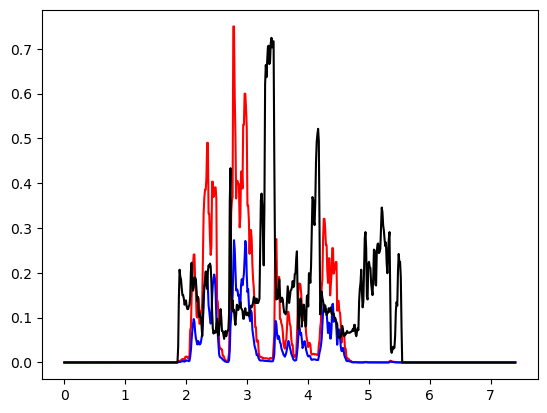

In [179]:
# plotting the data sample 1
dataTime = trainingSetProcessed["Timings"][0]
dataAE = trainingSetProcessed["Amplitude_Envelope"][0]
dataRMS = trainingSetProcessed["Root_Mean_Square_Energy"][0]
dataZCR = trainingSetProcessed["Zero-Crossing Rate"][0]

plt.plot(dataTime, dataAE, color="r")
plt.plot(dataTime, dataRMS, color="b")
plt.plot(dataTime, dataZCR, color="k")

In [202]:
# separate into training and validation
validDataProcessed = trainingSetProcessed.sample(n = 100, random_state=100)
trainingSetProcessed = trainingSetProcessed.drop(validData.index)

# grab key columns to train the neural network
trainData = trainingSetProcessed[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth", "affect", "phone_position"]]
testData = testSetProcessed[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth", "affect", "phone_position"]]
validData = validDataProcessed[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth", "affect", "phone_position"]]

trainData

,Amplitude_Envelope,Root_Mean_Square_Energy,Zero-Crossing Rate,Spectral Centroid,Spectral Bandwidth,affect,phone_position
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sadness,Place phone on the opposite side of the room i...
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral,Hold your phone next to your face but with the...
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral,Place phone on the opposite side of the room f...
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",neutral,Place phone on the opposite side of the room f...
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",disgust,Place phone 1-2 meters away face up on any sur...
...,...,...,...,...,...,...,...
3048,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sadness,Place phone as far away as possible while on o...
3049,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sadness,Place phone as far away as possible while on o...
3050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sadness,Place phone as far away as possible while on o...
3051,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fear,Place phone 1-2 meters away face down on a har...


In [260]:
# emotion dictionary mapping
emotionDictionary = {"neutral": 0, "anger": 1, "joy":2, "fear":3, "disgust":4, "surprise": 5, "sadness": 6}

In [276]:
# mapping the affect to a value
y_train = trainData['affect'].map(emotionDictionary)
y_valid = validData['affect'].map(emotionDictionary)
y_test = testData['affect'].map(emotionDictionary)

y_train = keras.utils.to_categorical(y_train, num_classes=7) 
y_valid = keras.utils.to_categorical(y_valid, num_classes=7)

print("y_train shape: {}".format(y_train.shape))
print("y_valid shape: {}".format(y_valid.shape))
print("y_test shape: {}".format(y_test.shape))

y_test = y_test.to_list()

y_train shape: (2853, 7)
y_valid shape: (100, 7)
y_test shape: (100,)


In [262]:
formattedDataTrain = []
for dataCollection in np.array(trainData[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth"]]):
    AE_data, RMS_data, ZCR_data, SC, SB = dataCollection
    formattedDataTrain.append([AE_data,RMS_data, ZCR_data, SC, SB])
x_train = np.array(formattedDataTrain)
print("training data shape: {}".format(x_train.shape))

formattedDataValid = []
for dataCollection in np.array(validData[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth"]]):
    AE_data, RMS_data, ZCR_data, SC, SB = dataCollection
    formattedDataValid.append([AE_data,RMS_data, ZCR_data, SC, SB])
x_valid = np.array(formattedDataValid)
print("valid data shape: {}".format(x_valid.shape))

formattedDataTest = []
for dataCollection in np.array(testData[["Amplitude_Envelope", "Root_Mean_Square_Energy", "Zero-Crossing Rate", "Spectral Centroid", "Spectral Bandwidth"]]):
    AE_data, RMS_data, ZCR_data, SC, SB = dataCollection
    formattedDataTest.append([AE_data,RMS_data, ZCR_data, SC, SB])
x_test = np.array(formattedDataTest)
print("test data shape: {}".format(x_test.shape))

training data shape: (2853, 5, 639)
valid data shape: (100, 5, 639)
test data shape: (100, 5, 639)


What is wanted from this model:
=====
    1. uses LSTMS
    2. using time series/frequency series data, determines a set emotion
    3. Architecture is Sequential, will consist of LSTM layer(s) with Dense layers followed by a softmax to identify the emotion
    
### Plan: 

    1. for each audio clip
    2. take vector of information in time series and feed into LSTM

In [263]:
### https://faroit.com/keras-docs/1.0.1/getting-started/sequential-model-guide/#the-merge-layer
data_dimension = 5
timesteps = len(trainingSetProcessed["Timings"][0])
numberClasses = 7

# data from audio clips LSTM
lstmModel = keras.Sequential()
lstmInput = keras.layers.Input(shape=(data_dimension, timesteps))
lstmModel.add(lstmInput)
lstmModel.add(LSTM(128, return_sequences=True))
lstmModel.add(LSTM(64, return_sequences=True))
lstmModel.add(LSTM(32))
lstmModel.add(keras.layers.Dropout(0.1))

# adding final dense layers
lstmModel.add(Dense(32, activation="relu"))
lstmModel.add(Dense(16, activation="relu"))
lstmModel.add(Dense(numberClasses, activation="softmax"))

lstmModel.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
lstmModel.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_113 (LSTM)                      │ (None, 5, 128)              │         393,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_114 (LSTM)                      │ (None, 5, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_115 (LSTM)                      │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 456,743 (1.74 MB)

 Trainable params: 456,743 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [316]:
y_train_tensor = tf.convert_to_tensor(y_train)
y_valid_tensor = tf.convert_to_tensor(y_valid)
y_test_tensor = tf.convert_to_tensor(y_test)

x_train_tensor = tf.convert_to_tensor(x_train)
x_valid_tensor = tf.convert_to_tensor(x_valid)
x_test_tensor = tf.convert_to_tensor(x_test)

# training the base LSTM model
lstmModel.fit(x = x_train_tensor, y = y_train_tensor, batch_size=256, epochs=25, validation_data=(x_valid_tensor, y_valid_tensor))

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2252 - loss: 1.8784 - val_accuracy: 0.1100 - val_loss: 1.9968
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2323 - loss: 1.8864 - val_accuracy: 0.1600 - val_loss: 1.9961
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2309 - loss: 1.8692 - val_accuracy: 0.1400 - val_loss: 1.9876
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2390 - loss: 1.8650 - val_accuracy: 0.1400 - val_loss: 2.0144
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2375 - loss: 1.8561 - val_accuracy: 0.1300 - val_loss: 2.0011
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2235 - loss: 1.8881 - val_accuracy: 0.1600 - val_loss: 2.0250
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2572 - loss: 1.8496 - val_accuracy: 0.1400 - val_loss: 2.0335
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2302 - loss: 1.8558 - val_accuracy: 0.0900 - v

In [317]:
positionDictionary = {"Hold your phone next to your face with the mic facing your mouth as you would in a phone conversation 1/19": 0,
                "Hold your phone next to your face but with the mic/phone facing away from your face 2/19": 1,
                "Hold your phone next to your face with your hand covering the mic 3/19": 2,
                "Hold your phone next to your hip with the back of phone on your palm 4/19": 3,
                "Hold your phone next to your hip with your hand covering the mic 5/19": 4,
                "Place your phone in your pocket 6/19": 5,
                "Place your phone in a bag and hold it next to your hip 7/19": 6,
                "Place phone 1-2 meters away face up on any surface 8/19": 7,
                "Place phone 1-2 meters away face down on a hard surface 9/19": 8,
                "Place phone 1-2 meters away face down on a soft surface 10/19": 9,
                "Place phone 1-2 meters away in a bag 11/19": 10,
                "Place phone on the opposite side of the room face up on any surface 12/19": 11,
                "Place phone on the opposite side of the room face down on a hard surface 13/19": 12,
                "Place phone on the opposite side of the room face down on a soft surface 14/19": 13,
                "Place phone on the opposite side of the room in a bag 15/19": 14,
                "Place phone as far away as possible while on on the opposite side of a wall from you face up on any surface 16/19": 15,
                "Place phone as far away as possible while on on the opposite side of a wall from you face down on a hard surface 17/19": 16,
                "Place phone as far away as possible while on on the opposite side of a wall from you face down on a soft surface 18/19": 17,
                "Place phone as far away as possible while on on the opposite side of a wall from you in a bag 19/19": 18}

# mapping the position to a value
xPos_train = np.array(trainData['phone_position'].map(positionDictionary).to_list())
xPos_valid = np.array(validData['phone_position'].map(positionDictionary).to_list())
xPos_test = np.array(testData['phone_position'].map(positionDictionary).to_list())

print("xPos_train shape: {}".format(xPos_train.shape))
print("xPos_valid shape: {}".format(xPos_valid.shape))
print("xPos_test shape: {}".format(xPos_test.shape))

xPos_train shape: (2853,)
xPos_valid shape: (100,)
xPos_test shape: (100,)


In [318]:
# LSTM model with distance incorporated
data_dimension = 5
timesteps = len(trainingSetProcessed["Timings"][0])
numberClasses = 7

# data from audio clips LSTM
lstmInput = keras.layers.Input(shape=(data_dimension, timesteps))
lstmModel2 = LSTM(64, return_sequences=True)(lstmInput)
lstmModel2 = LSTM(32, return_sequences=True)(lstmModel2)
lstmModel2 = LSTM(32)(lstmModel2)
lstmModel2 = keras.layers.Dropout(0.1)(lstmModel2)
lstmModel2 = keras.layers.Flatten()(lstmModel2)

# Adding the distance parameter
distanceInput = keras.layers.Input(shape=(1,))
distance = keras.layers.Flatten()(distanceInput)

# merged model
mergedLSTM = keras.layers.concatenate([lstmModel2, distance])

# adding final dense layers
mergedLSTM = Dense(32, activation="relu")(mergedLSTM)
mergedLSTM = Dense(16, activation="relu")(mergedLSTM)
mergedLSTM = Dense(numberClasses, activation="softmax")(mergedLSTM)

# forming the merged Model
LSTM_distance = keras.Model(inputs=[lstmInput, distanceInput], outputs=mergedLSTM)
LSTM_distance.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

LSTM_distance.summary()

Model: "functional_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)   │ (None, 5, 639)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_119 (LSTM)               │ (None, 5, 64)             │         180,224 │ input_layer_61[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_120 (LSTM)               │ (None, 5, 32)             │          12,416 │ lstm_119[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_121 (LSTM)               │ (None, 32)                │           8,320 │ lstm_120[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_17 (Dropout)          │ (None, 32)                │               0 │ lstm_121[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_62 (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_32 (Flatten)          │ (None, 32)                │               0 │ dropout_17[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_33 (Flatten)          │ (None, 1)                 │               0 │ input_layer_62[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_21 (Concatenate)  │ (None, 33)                │               0 │ flatten_32[0][0],          │
│                               │                           │                 │ flatten_33[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_91 (Dense)              │ (None, 32)                │           1,088 │ concatenate_21[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_92 (Dense)              │ (None, 16)                │             528 │ dense_91[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_93 (Dense)              │ (None, 7)                 │             119 │ dense_92[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 202,695 (791.78 KB)

 Trainable params: 202,695 (791.78 KB)

 Non-trainable params: 0 (0.00 B)

In [319]:
# training the merged LSTM model
LSTM_distance.fit(x = [x_train_tensor, xPos_train], y = y_train_tensor, batch_size=128, epochs=20, validation_data=([x_valid_tensor, xPos_valid], y_valid_tensor))

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1520 - loss: 1.9743 - val_accuracy: 0.1200 - val_loss: 1.9462
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1445 - loss: 1.9457 - val_accuracy: 0.1200 - val_loss: 1.9465
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1507 - loss: 1.9455 - val_accuracy: 0.1200 - val_loss: 1.9466
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1456 - loss: 1.9458 - val_accuracy: 0.1200 - val_loss: 1.9466
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1414 - loss: 1.9457 - val_accuracy: 0.1200 - val_loss: 1.9464
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1503 - loss: 1.9457 - val_accuracy: 0.1200 - val_loss: 1.9466
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1431 - loss: 1.9461 - val_accuracy: 0.1200 - val_loss: 1.9469
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1378 - loss: 1.9456 - val_accuracy: 0.1200 - val_loss

In [320]:
# importing metrics
from sklearn.model_selection import cross_val_score
import sklearn.metrics as skMetrics

In [321]:
# predicting on test data
LSTM_Base_testResults = lstmModel.predict(x_test)
testResults_base = []
for index in range(0, len(LSTM_Base_testResults)):
    emotionNum = list(LSTM_Base_testResults[index]).index(max(LSTM_Base_testResults[index]))
    testResults_base.append(emotionNum)

LSTM_Distance_testResults = LSTM_distance.predict([x_test,xPos_test])
testResults_pos = []
for index in range(0, len(LSTM_Distance_testResults)):
    emotionNum = list(LSTM_Distance_testResults[index]).index(max(LSTM_Distance_testResults[index]))
    testResults_pos.append(emotionNum)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [322]:
base_AS = skMetrics.accuracy_score(y_test, testResults_base)
base_PS = skMetrics.precision_score(y_test, testResults_base, average="macro")
base_RS = skMetrics.recall_score(y_test, testResults_base, average="macro")
base_f1Score = skMetrics.f1_score(y_test, testResults_base, average="macro")
base_confusion =skMetrics.confusion_matrix(y_test, testResults_base)

position_AS = skMetrics.accuracy_score(y_test, testResults_pos)
position_PS = skMetrics.precision_score(y_test, testResults_pos, average="macro")
position_RS = skMetrics.recall_score(y_test, testResults_pos, average="macro")
position_f1Score = skMetrics.f1_score(y_test, testResults_pos, average="macro")
position_confusion = skMetrics.confusion_matrix(y_test, testResults_pos)

A:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
A:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [326]:
print("Base Precision Score: {}".format(base_PS))
print("Base Accuracy Score: {}".format(base_AS))
print("Base Recall Score: {}".format(base_RS))
print("Base F1 Score: {}".format(base_f1Score))

print("Prosition Included Precision Score: {}".format(position_PS))
print("Prosition Included Accuracy Score: {}".format(position_AS))
print("Prosition Included Recall Score: {}".format(position_RS))
print("Prosition Included F1 Score: {}".format(position_f1Score))

Base Precision Score: 0.13241644483880508
Base Accuracy Score: 0.16
Base Recall Score: 0.16544348508634224
Base F1 Score: 0.12058980999073164
Prosition Included Precision Score: 0.018571428571428572
Prosition Included Accuracy Score: 0.13
Prosition Included Recall Score: 0.14285714285714285
Prosition Included F1 Score: 0.03286978508217447


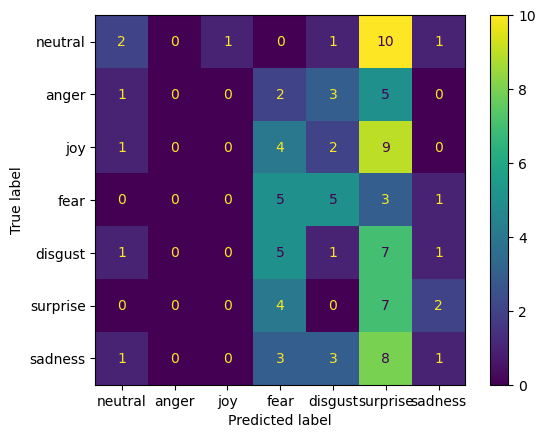

In [324]:
base_confusionPlot = skMetrics.ConfusionMatrixDisplay(base_confusion, display_labels=emotionDictionary.keys())
base_confusionPlot.plot()

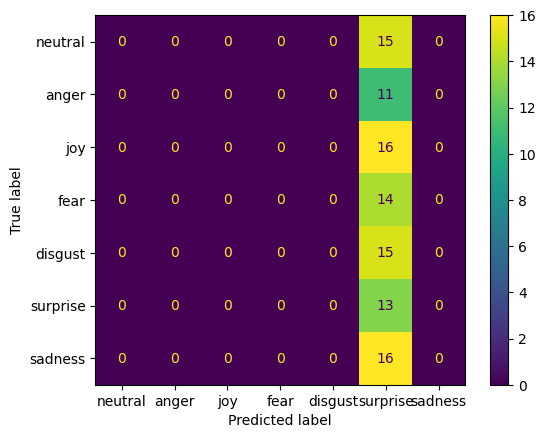

In [325]:
position_confusionPlot = skMetrics.ConfusionMatrixDisplay(position_confusion, display_labels=emotionDictionary.keys())
position_confusionPlot.plot()